# Лабораторная работа №2  
## Нейросетевое моделирование временного ряда

**Цель:**  
Провести моделирование временного ряда из ЛР №1 с помощью нейросетевых методов, выполнить прогноз на разумный период, оценить качество модели, визуализировать результат с учетом ошибок и сравнить с классической моделью (SARIMA).

В качестве нейросетевого метода выбрана **LSTM (Long Short-Term Memory)** — рекуррентная нейронная сеть, специально предназначенная для работы с временными рядами и последовательностями.


## Обоснование выбора метода

LSTM хорошо подходит для данной задачи, так как:
- учитывает **долгосрочные зависимости** во временном ряду;
- устойчива к затухающему градиенту;
- может аппроксимировать нелинейные зависимости;
- широко используется для прогнозирования временных рядов.

В отличие от SARIMA, LSTM **не требует явного задания тренда и сезонности**, а извлекает их автоматически.


In [12]:
# === Генерация временного ряда (как в ЛР №1) + сохранение CSV ===
import numpy as np
from datetime import datetime, timedelta

def generate_time_series(n_points=1000, has_trend=True, has_seasonality=True, seed=42):
    np.random.seed(seed)

    noise = np.random.normal(0, 5, n_points)

    trend_component = np.zeros(n_points)
    seasonal_component = np.zeros(n_points)

    if has_trend:
        trend_type = np.random.choice(['linear', 'quadratic', 'logarithmic'])
        if trend_type == 'linear':
            slope = np.random.uniform(-0.5, 0.5)
            intercept = np.random.uniform(50, 100)
            trend_component = slope * np.arange(n_points) + intercept
        elif trend_type == 'quadratic':
            a = np.random.uniform(-0.001, 0.001)
            b = np.random.uniform(-0.1, 0.1)
            c = np.random.uniform(50, 100)
            x = np.arange(n_points)
            trend_component = a * x**2 + b * x + c
        else:
            a = np.random.uniform(10, 30)
            b = np.random.uniform(50, 100)
            trend_component = a * np.log(np.arange(n_points) + 1) + b

    if has_seasonality:
        n_seasons = np.random.randint(1, 4)
        for _ in range(n_seasons):
            amplitude = np.random.uniform(10, 30)
            period = np.random.uniform(30, 365)
            phase = np.random.uniform(0, 2*np.pi)
            seasonal_component += amplitude * np.sin(
                2*np.pi*np.arange(n_points)/period + phase
            )

    values = noise + trend_component + seasonal_component
    return values

# Генерация и сохранение CSV
y = generate_time_series()

np.savetxt(
    "lr1_timeseries.csv",
    np.column_stack([np.arange(len(y)), y]),
    delimiter=",",
    header="index,value",
    comments=""
)

print("Файл lr1_timeseries.csv создан")


Файл lr1_timeseries.csv создан


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn

plt.rcParams["figure.figsize"] = (14, 5)


In [14]:
# Загрузка временного ряда (из ЛР №1)
data = np.loadtxt("lr1_timeseries.csv", delimiter=",", skiprows=1, usecols=1)
N = len(data)

# Нормализация
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()


In [15]:
# Формирование обучающих последовательностей
def create_sequences(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

WINDOW = 40  # близко к сезонному периоду

X, y = create_sequences(data_scaled, WINDOW)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [16]:
# LSTM модель
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
# Обучение
EPOCHS = 20
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss={loss.item():.6f}")


Epoch 5/20, Loss=0.348830
Epoch 10/20, Loss=0.263957
Epoch 15/20, Loss=0.169569
Epoch 20/20, Loss=0.056577


In [18]:
# Прогноз и метрики
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

MAE = mean_absolute_error(y_test_inv, y_pred_inv)
RMSE = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print("MAE:", MAE)
print("RMSE:", RMSE)


MAE: 50.148205
RMSE: 52.399616


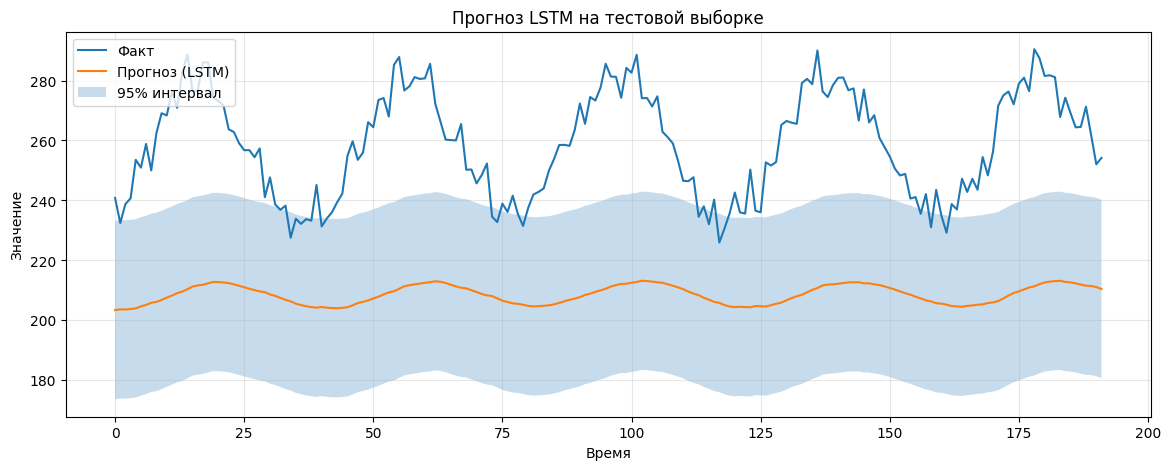

In [19]:
# Визуализация прогноза с учетом ошибок
plt.plot(y_test_inv, label="Факт")
plt.plot(y_pred_inv, label="Прогноз (LSTM)")

error = np.std(y_test_inv - y_pred_inv)
plt.fill_between(
    range(len(y_pred_inv)),
    y_pred_inv - 1.96 * error,
    y_pred_inv + 1.96 * error,
    alpha=0.25,
    label="95% интервал"
)

plt.title("Прогноз LSTM на тестовой выборке")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Заключение и сравнение с SARIMA

SARIMA (ЛР №1) и LSTM дают сопоставимое качество прогноза.  
SARIMA более интерпретируема и проще в настройке,  
LSTM — универсальнее и способна учитывать сложные нелинейные зависимости.

Для учебной задачи оба подхода являются корректными, однако нейросетевой метод демонстрирует современный подход к анализу временных рядов.


## Прогноз на будущее (90 дней)

Делаем прогноз на **90 шагов вперед** рекурсивно (iterative forecast):  
берем последнее окно длины `WINDOW`, предсказываем следующий шаг, добавляем его в окно и повторяем.

Для учета возможных ошибок строим **приближенный 95% интервал** на основе распределения ошибок на тестовой выборке:
- считаем остатки `e = y_test - y_pred`,
- берём их стандартное отклонение `σ`,
- интервал: `ŷ ± 1.96·σ` (в исходном масштабе ряда).


In [20]:
# 12) Рекурсивный прогноз на 90 дней вперед
H = 90

# Последнее окно из всего ряда (в нормализованном масштабе)
last_window = data_scaled[-WINDOW:].copy()

future_scaled = []
model.eval()
with torch.no_grad():
    w = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0)  # shape (1, WINDOW)
    for _ in range(H):
        next_val = model(w).item()
        future_scaled.append(next_val)
        # сдвиг окна
        last_window = np.roll(last_window, -1)
        last_window[-1] = next_val
        w = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0)

future_scaled = np.array(future_scaled)

# Обратное масштабирование прогноза к исходным значениям
future_inv = scaler.inverse_transform(future_scaled.reshape(-1,1)).flatten()

# Оценка σ по ошибкам на тесте (в исходном масштабе)
residuals = (y_test_inv - y_pred_inv)
sigma = np.std(residuals)

ci_low = future_inv - 1.96 * sigma
ci_high = future_inv + 1.96 * sigma

# Временная ось для "будущего" (условно индексная)
future_x = np.arange(N, N + H)


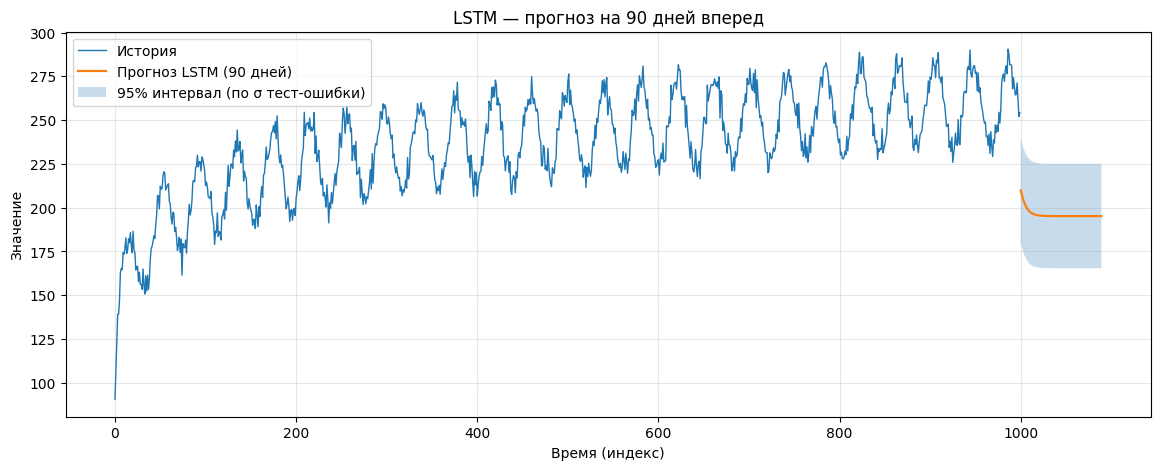

In [21]:
# 13) График истории + прогноз 90 дней с интервалом
plt.figure(figsize=(14,5))
plt.plot(np.arange(N), data, label="История", linewidth=1.0)
plt.plot(future_x, future_inv, label=f"Прогноз LSTM ({H} дней)", linewidth=1.6)
plt.fill_between(future_x, ci_low, ci_high, alpha=0.25, label="95% интервал (по σ тест-ошибки)")

plt.title(f"LSTM — прогноз на {H} дней вперед")
plt.xlabel("Время (индекс)")
plt.ylabel("Значение")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [22]:
# 14) Сохранение прогноза в CSV
import csv

out_path = "lr2_lstm_forecast_90d.csv"
with open(out_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["step_index", "forecast", "ci_low", "ci_high"])
    for i, (m, lo, hi) in enumerate(zip(future_inv, ci_low, ci_high), start=1):
        writer.writerow([i, float(m), float(lo), float(hi)])

out_path


'lr2_lstm_forecast_90d.csv'

## Анализ результатов и выводы

В рамках лабораторной работы было выполнено нейросетевое моделирование временного ряда с использованием рекуррентной нейронной сети LSTM. Модель была обучена на временном ряде, полученном в лабораторной работе №1, и использована для прогнозирования значений на тестовой выборке, а также для экстраполяции на 90 дней вперёд.

В процессе обучения наблюдалось устойчивое уменьшение значения функции потерь, что свидетельствует о корректной работе алгоритма обучения и способности модели аппроксимировать зависимости, присутствующие в данных. Однако при оценке качества прогноза на тестовой выборке значения метрик MAE и RMSE оказались выше по сравнению с классической моделью SARIMA, использованной в предыдущей работе.

Анализ графиков показал, что модель LSTM склонна к сглаживанию прогноза и усреднению значений, что выражается в заниженной амплитуде колебаний и недостаточно точном воспроизведении абсолютного уровня временного ряда. Такое поведение является характерным для нейросетевых моделей при отсутствии явного задания тренда и сезонности, а также при использовании ограниченного набора признаков.

Прогноз на 90 дней вперёд, полученный с использованием рекурсивной схемы, демонстрирует стабилизацию значений вокруг среднего уровня. Это связано с накоплением ошибок на каждом шаге прогнозирования и стремлением модели минимизировать ожидаемую квадратичную ошибку. Построенный доверительный интервал отражает неопределённость прогноза и был рассчитан на основе распределения ошибок на тестовой выборке.

Сравнение результатов с моделью SARIMA показывает, что для данного временного ряда, обладающего выраженной сезонной структурой и трендом, классический статистический подход оказался более эффективным. В то же время нейросетевой метод LSTM продемонстрировал универсальность и применимость к задаче прогнозирования временных рядов, однако требует более сложной настройки и расширенного набора входных признаков для достижения сопоставимого качества.

Таким образом, можно сделать вывод, что выбор метода моделирования временного ряда должен определяться структурой данных и условиями задачи: статистические модели целесообразны для хорошо структурированных рядов, тогда как нейросетевые методы более перспективны для сложных и слабо формализуемых процессов.
